In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

In [3]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
PassengerId = test_data['PassengerId']

In [6]:
categorical_columns = train_data.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical columns:", categorical_columns)

Categorical columns: ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']


In [7]:
na_columns = train_data.columns[train_data.isna().any()]
print(na_columns)

Index(['Age', 'Cabin', 'Embarked'], dtype='object')


In [8]:
data = [train_data, test_data]

for i in data:
#     i['Ticket_type'] = i['Ticket'].astype('category').cat.codes
#     i['Has_Cabin'] = i['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
#     i['FamilySize'] = i['SibSp'] + i['Parch'] + 1
#     i['IsAlone'] = 0
#     i.loc[i['FamilySize'] == 1, 'IsAlone'] = 1
#     i['Embarked'] = i['Embarked'].fillna('S')
#     i['Embarked'] = i['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    i['Fare'] = i['Fare'].fillna(train_data['Fare'].median())
    i.loc[ i['Fare'] <= 7.91, 'Fare'] = 0
    i.loc[(i['Fare'] > 7.91) & (i['Fare'] <= 14.454), 'Fare'] = 1
    i.loc[(i['Fare'] > 14.454) & (i['Fare'] <= 31), 'Fare'] = 2
    i.loc[ i['Fare'] > 31, 'Fare'] = 3
    i['Fare'] = i['Fare'].astype(int)
    i['Age'] = i['Age'].fillna(train_data['Age'].median())
    i.loc[ i['Age'] <= 16, 'Age'] = 0
    i.loc[(i['Age'] > 16) & (i['Age'] <= 32), 'Age'] = 1
    i.loc[(i['Age'] > 32) & (i['Age'] <= 48), 'Age'] = 2
    i.loc[(i['Age'] > 48) & (i['Age'] <= 64), 'Age'] = 3
    i.loc[ i['Age'] > 64, 'Age'] = 4;
    i['Sex'] = i['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

In [9]:
train_data = train_data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp', 'Parch', 'Embarked'], axis = 1)
test_data = test_data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp', 'Parch', 'Embarked'], axis = 1)

In [10]:
train_data

,Survived,Pclass,Sex,Age,Fare
0,0,3,1,1.0,0
1,1,1,0,2.0,3
2,1,3,0,1.0,1
3,1,1,0,2.0,3
4,0,3,1,2.0,1
...,...,...,...,...,...
886,0,2,1,1.0,1
887,1,1,0,1.0,2
888,0,3,0,1.0,2
889,1,1,1,1.0,2


<Axes: >

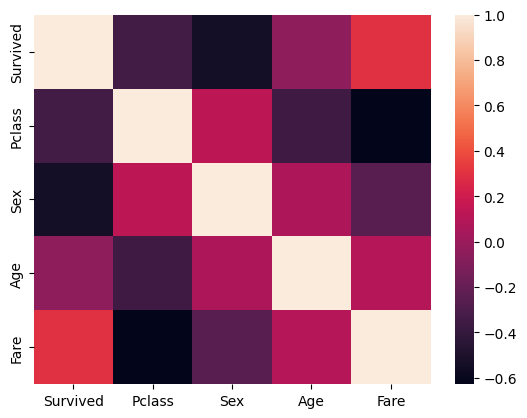

In [11]:
sns.heatmap(train_data.astype(float).corr())

In [12]:
y_train = train_data['Survived'].to_numpy()
train_data = train_data.drop(['Survived'], axis=1)

In [13]:
gbm1 = xgb.XGBClassifier(
    n_estimators= 2000,
    max_depth= 4,
    min_child_weight= 2,
    gamma=0.9,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread= -1,
    scale_pos_weight=1).fit(train_data, y_train)

predictions1 = gbm1.predict(test_data)

In [14]:
gbm2 = xgb.XGBClassifier(
    n_estimators= 2000,
    max_depth= 10,
    min_child_weight= 2,
    gamma=0.9,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread= -1,
    scale_pos_weight=1).fit(train_data, y_train)

predictions2 = gbm2.predict(test_data)

In [15]:
gbm3 = xgb.XGBClassifier(
    n_estimators= 2000,
    max_depth= 5,
    min_child_weight= 2,
    gamma=1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread= -1,
    scale_pos_weight=1).fit(train_data, y_train)

predictions3 = gbm3.predict(test_data)

In [16]:
output = pd.DataFrame({
    'PassengerId': PassengerId, 
#      'Survived': 0.3*predictions1 + 0.4*predictions2 + 0.3*predictions3
    'Survived': predictions1
    })
output['Survived'] = output['Survived'].apply(lambda f: 1 if f>=0.5 else 0)
output

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,1
414,1306,1
415,1307,0
416,1308,1


In [17]:
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
